In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score


# Import the relevant models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


In [20]:
ww = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-white.csv', sep=';')

In [21]:
ww['quality_label'] = ww['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# here we are transforming these labels into categrical data type (specific to pandas) instead of simple string
ww['quality_label'] = pd.Categorical(ww['quality_label'],
categories=['low', 'medium', 'high'])

In [22]:

le = LabelEncoder()
ww['encoded_quality_label'] = le.fit_transform(ww['quality_label'])  


In [ ]:
# Swap 0 for 3 to make the order make sense from low to high
ww['encoded_quality_label'].replace(0,3,inplace=True)

In [24]:
ww.drop(['quality_label'], axis=1, inplace=True)

In [25]:
ww.drop(['quality'], axis=1, inplace=True)
display(ww.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,encoded_quality_label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


## Select the features to use as inputs

In [26]:
ww_select = ww[['fixed acidity', 'volatile acidity', 'chlorides', 'alcohol']]
display(ww_select.head())

,fixed acidity,volatile acidity,chlorides,alcohol
0,7.0,0.27,0.045,8.8
1,6.3,0.30,0.049,9.5
2,8.1,0.28,0.050,10.1
3,7.2,0.23,0.058,9.9
4,7.2,0.23,0.058,9.9


## Create column-vector for quality_label (y)

In [27]:
y_ww_quality = ww.encoded_quality_label
display(y_ww_quality.head())
display(y_ww_quality.shape)

0    2
1    2
2    2
3    2
4    2
Name: encoded_quality_label, dtype: int32

(4898,)

## Split into train and test data

In [28]:
ww_features_train, ww_features_test, ww_quality_train, ww_quality_test = train_test_split(ww_select,y_ww_quality,test_size=0.2, random_state=19)

## Scale wine features to even out their impact on the model

In [29]:

# Also try different methods of normalization/standardization
scaler = StandardScaler()
ww_features_train_scaled = scaler.fit_transform(ww_features_train)
ww_features_test_scaled = scaler.transform(ww_features_test)

## Create a function with several ML models at once

In [98]:
def model_accuracy_comparison(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Logistic Regression', LogisticRegression(max_iter=1000)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('Support Vector Classification', SVC()),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        ('K Nearest Neighbors', KNeighborsClassifier())
        
    ]
    # Create a figure to accommodate the heatmaps for each model
    fig, axs = plt.subplots(1, len(classifiers), figsize=(20, 3))
    
    metrics_df = pd.DataFrame(columns=['Classifier', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

    for idx, (name, clf) in enumerate(classifiers):
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        test_predictions = clf.predict(X_test)
        
        # Calculate metrics
        train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
        test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
        precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
        recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
        f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
        cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
        
        # Create confusion matrix and heatmap of it
        cm = confusion_matrix(y_test, test_predictions)

        # Create a mask for off-diagonal cells
        mask = np.ones_like(cm, dtype=bool)
        np.fill_diagonal(mask, 0)

        bleh_green_palette = sns.diverging_palette(70, 100, s=100, l=50, as_cmap=True)
        correct_cmap = sns.color_palette("viridis_r", as_cmap=True)
        green_palette = sns.color_palette(palette='Greens_d')
        summer_palette = sns.color_palette(palette='summer_r')
        incorrect_cmap = sns.color_palette("flare", as_cmap=True)

        
        # Plot the heatmap with the mask
        sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, ax=axs[idx])
        sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, ax=axs[idx], vmax=cm.max())
        axs[idx].set_title(name)
        axs[idx].set_xlabel('Predicted labels')
        axs[idx].set_ylabel('True labels')

        metrics_row = {
            'Classifier': name,
            'Test Accuracy': test_accuracy,
            'Train Accuracy': train_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            "Cohen's Kappa": cohen_kappa
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])]).reset_index(drop=True)
        metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
    
    # Display the heatmap visualization
    plt.tight_layout()
    plt.show()

    display(metrics_df)

Call the big function on white wine features (input) quality (output)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


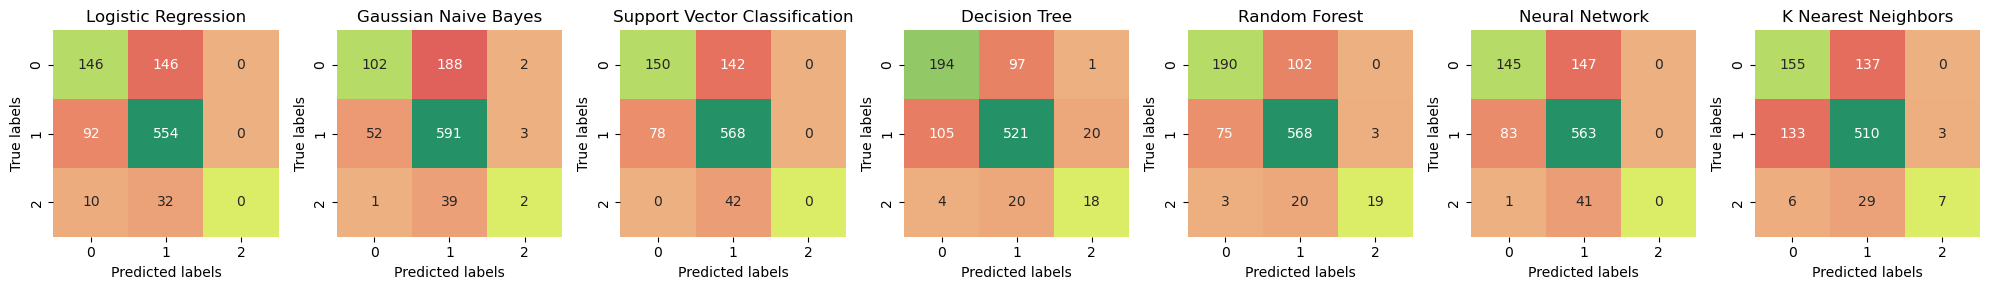

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest,79.29,99.92,79.09,79.29,78.81,0.54
1,Decision Tree,74.80,99.92,74.89,74.80,74.83,0.47
2,Support Vector Classification,73.27,72.21,69.39,73.27,70.75,0.37
3,Neural Network,72.24,71.44,68.28,72.24,69.72,0.35
4,Logistic Regression,71.43,70.09,67.43,71.43,69.11,0.34
5,Gaussian Naive Bayes,70.92,67.71,68.46,70.92,67.17,0.28
6,K Nearest Neighbors,68.57,79.53,68.44,68.57,67.78,0.31


In [99]:
model_accuracy_comparison(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)

In [46]:
def model_cross_val(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Logistic Regression', LogisticRegression(max_iter=1000)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('Support Vector Classification', SVC()),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        ('K Nearest Neighbors', KNeighborsClassifier())
        
    ]

    cross_val_metrics_df = pd.DataFrame(columns=['Classifier', 'Mean Accuracy', 'Standard Deviation'])

    
    for name, clf in classifiers:

        # Perform 5-fold cross-validation
        scores = cross_val_score(clf, X_train, y_train, cv=5)

        # Calculate the mean and standard deviation of the scores
        mean_score = scores.mean().round(3)
        std_dev = scores.std().round(3)

        cross_val_metrics_row = {
            'Classifier': name,
            'Mean Accuracy': mean_score,
            'Standard Deviation': std_dev
        }

        cross_val_metrics_df = pd.concat([cross_val_metrics_df, pd.DataFrame([cross_val_metrics_row])]).reset_index(drop=True)
        cross_val_metrics_df = cross_val_metrics_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
    
    return cross_val_metrics_df

In [47]:
models_cross_val_df = model_cross_val(ww_features_train_scaled, ww_quality_train, ww_features_test_scaled, ww_quality_test)
display(models_cross_val_df)

,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest,0.764,0.013
1,Support Vector Classification,0.715,0.006
2,Neural Network,0.709,0.012
3,K Nearest Neighbors,0.704,0.008
4,Decision Tree,0.703,0.010
5,Logistic Regression,0.702,0.012
6,Gaussian Naive Bayes,0.676,0.011


In [48]:
# Select features
ww_select2 = ww[['alcohol', 'volatile acidity']]
# Split data
ww_features_train2, ww_features_test2, ww_quality_train2, ww_quality_test2 = train_test_split(ww_select2,y_ww_quality,test_size=0.2, random_state=19)
# Scale features
scaler = StandardScaler()
ww_features_train_scaled2 = scaler.fit_transform(ww_features_train2)
ww_features_test_scaled2 = scaler.transform(ww_features_test2)

# Call our two previously defined functions
results_df2 = model_accuracy_comparison(ww_features_train_scaled2, ww_quality_train2, ww_features_test_scaled2, ww_quality_test2)
display(results_df2)
model_cross_val_df2 = model_cross_val(ww_features_train_scaled2, ww_quality_train2, ww_features_test_scaled2, ww_quality_test2)
display(model_cross_val_df2)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Neural Network,72.76,71.69,69.06,72.76,70.70,0.38
1,Random Forest,72.55,82.52,72.31,72.55,72.27,0.41
2,Gaussian Naive Bayes,72.24,70.34,68.80,72.24,69.56,0.34
3,Support Vector Classification,72.24,71.34,68.35,72.24,69.87,0.35
4,Logistic Regression,71.84,70.21,67.83,71.84,69.49,0.35
5,K Nearest Neighbors,70.41,77.00,69.27,70.41,69.52,0.35
6,Decision Tree,70.31,82.52,71.01,70.31,70.39,0.38


,Classifier,Mean Accuracy,Standard Deviation
0,Support Vector Classification,0.712,0.007
1,Neural Network,0.710,0.007
2,Logistic Regression,0.702,0.010
3,Gaussian Naive Bayes,0.702,0.009
4,Random Forest,0.690,0.013
5,K Nearest Neighbors,0.686,0.006
6,Decision Tree,0.671,0.007


# &uarr; WW quality prediction accuracy also lower with just 2 features

In [50]:
# Select ALL features
ww_select3 = ww.drop(['encoded_quality_label'], axis=1)
# Split data
ww_features_train3, ww_features_test3, ww_quality_train3, ww_quality_test3 = train_test_split(ww_select3,y_ww_quality,test_size=0.2, random_state=19)
# Scale features
scaler = StandardScaler()
ww_features_train_scaled3 = scaler.fit_transform(ww_features_train3)
ww_features_test_scaled3 = scaler.transform(ww_features_test3)

# Call our two previously defined functions
results_df3 = model_accuracy_comparison(ww_features_train_scaled3, ww_quality_train3, ww_features_test_scaled3, ww_quality_test3)
display(results_df3)
model_cross_val_df3 = model_cross_val(ww_features_train_scaled3, ww_quality_train3, ww_features_test_scaled3, ww_quality_test3)
display(model_cross_val_df3)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest,82.04,100.00,82.24,82.04,81.54,0.60
1,Decision Tree,75.00,100.00,75.17,75.00,75.07,0.48
2,Support Vector Classification,74.18,77.62,70.39,74.18,71.91,0.40
3,Neural Network,72.96,72.28,69.07,72.96,70.09,0.35
4,Logistic Regression,72.14,71.64,68.25,72.14,69.81,0.35
5,K Nearest Neighbors,70.61,80.91,69.71,70.61,69.82,0.35
6,Gaussian Naive Bayes,65.20,64.24,65.99,65.20,65.53,0.28


,Classifier,Mean Accuracy,Standard Deviation
0,Random Forest,0.798,0.009
1,Support Vector Classification,0.744,0.002
2,Neural Network,0.738,0.006
3,Decision Tree,0.726,0.009
4,K Nearest Neighbors,0.716,0.018
5,Logistic Regression,0.711,0.015
6,Gaussian Naive Bayes,0.642,0.019
